# Data processing 
from initial_micro_data_wrangling as netcdf

In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat

In [4]:
arctic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/arctic_mmp.nc"
arctic_dataset = Dataset(arctic_nc)
arctic_ds = xr.open_dataset(arctic_nc)

In [5]:
# trace back depth as a variable from pressure (how useful?)
arctic_ds["z"] = -arctic_ds.PRESSURE # pressure in dbar to z

## Bin data

In [8]:
# correlate depth samples to actual depth
# assume that pressure (decibars) of the water correlates to the depth (m)
multiply_factor = arctic_ds.PRESSURE.max().item()/arctic_ds.depth.max().item()
arctic_ds["depth"] = arctic_ds["depth"]*multiply_factor

In [59]:
bin_ds = arctic_ds
# group data by depth bins
# adjust the labels to reflect the start of each interval
bin_size = np.arange(0, 300.1, 1)
bin_labels = [edge for edge in bin_size[:-1]]
grouped = bin_ds.groupby_bins('depth', bin_size, labels=bin_labels)
# calculate mean of each bin
binned_data = grouped.mean(dim='depth')
binned_data = binned_data.rename({'depth_bins': 'depth'})
binned_data

<xarray.Dataset>
Dimensions:      (depth: 300, profiles: 871, single: 1)
Coordinates:
  * depth        (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Dimensions without coordinates: profiles, single
Data variables:
    LATITUDE     (depth, profiles, single) float64 65.23 65.24 ... 65.73 65.73
    LONGITUDE    (depth, profiles, single) float64 -166.6 -166.6 ... -168.8
    TIME         (depth, profiles, single) float64 7.362e+05 ... 7.362e+05
    EPSILON      (depth, profiles) float64 nan nan nan nan ... nan nan nan nan
    PRESSURE     (depth, single) float64 0.625 1.625 2.625 ... 297.6 298.6 299.6
    PSAL         (depth, profiles) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TEMPERATURE  (depth, profiles) float64 nan nan nan 13.6 ... nan nan nan nan
    z            (depth, single) float64 -0.625 -1.625 -2.625 ... -298.6 -299.6

In [83]:
lat = binned_data.LATITUDE
lon = binned_data.LONGITUDE

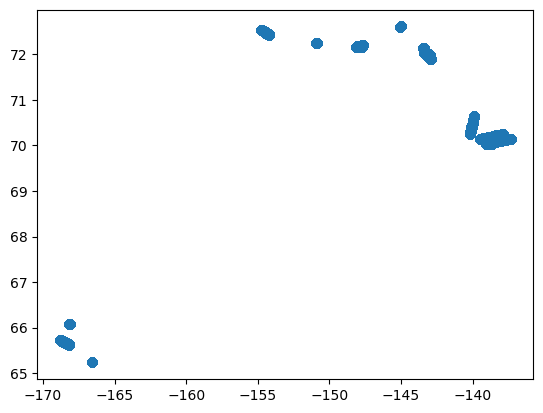

In [84]:
plt.scatter(lon, lat)

Text(0.5, 0, 'Temperature')

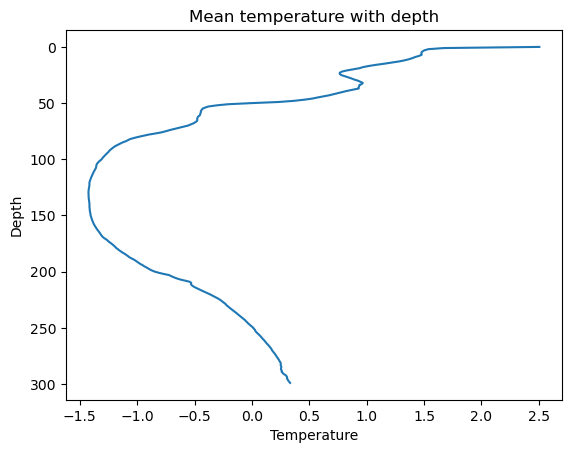

In [85]:
plt.plot(binned_data.TEMPERATURE.mean(dim="profiles"),binned_data.depth)
plt.gca().invert_yaxis()  # invert the y-axis (depth axis)
plt.title("Mean temperature with depth")
plt.ylabel("Depth")
plt.xlabel("Temperature")

In [1]:
arctic_ds.P

NameError: name 'arctic_ds' is not defined

In nc dataset, can find time, lat, lon, epsilon, pressure, psal, temperature.
dimensions for this dataset are lengths, profiles and depth

lit review on Arctic and CC and beaufort sea

Understabding Arctic turbulence: beaufort gyre

The Arctic Ocean's beaufort gyre

## Omit NaNs

In [38]:
# Check the shape of the original dataset
print("Original dataset shape:", binned_data.sizes)
print("Original dataset NaN count:\n", binned_data.isnull().sum())

# Check the shape of the masked dataset
print("Masked dataset shape:", ds_masked.sizes)
print("Masked dataset NaN count:\n", ds_masked.isnull().sum())

Original dataset shape: Frozen({'depth': 30, 'profiles': 871, 'single': 1})
Original dataset NaN count:
 <xarray.Dataset>
Dimensions:      ()
Data variables:
    LATITUDE     int64 0
    LONGITUDE    int64 0
    TIME         int64 0
    EPSILON      int64 12171
    PRESSURE     int64 0
    PSAL         int64 59
    TEMPERATURE  int64 11907
Masked dataset shape: Frozen({'depth': 30, 'profiles': 871, 'single': 1})
Masked dataset NaN count:
 <xarray.Dataset>
Dimensions:      ()
Data variables:
    LATITUDE     int64 13902
    LONGITUDE    int64 13902
    TIME         int64 13902
    EPSILON      int64 26073
    PRESSURE     int64 13902
    PSAL         int64 13961
    TEMPERATURE  int64 25809


## Convert to standard size of dataframe
correct variable names

# apply mask to get rid of rows with NaN values in var2 and var3
mask = xr.ufuncs.logical_not(xr.ufuncs.isnan(binned_data['TEMPERATURE']) | xr.ufuncs.isnan(binned_data['PSAL']) | xr.ufuncs.isnan(binned_data['EPSILON']))
ds_masked = binned_ds.where(mask, drop=True)

## Other plots

plot histograms and distributions

## Change variable names and save for preprocessing

In [60]:
binned_data = binned_data.rename({'PSAL': 'S', 'TEMPERATURE': 'T', 'LONGITUDE': 'longitude', 'LATITUDE':'latitude', "EPSILON":"eps", "PRESSURE":"P"})
binned_data.coords["depth"] = binned_data.coords["depth"].astype(int)
binned_data = binned_data.assign_coords(longitude=binned_data['longitude'], latitude=binned_data['latitude'])
binned_data = binned_data.rename_dims({"profiles": "profile"})

In [61]:
binned_data

<xarray.Dataset>
Dimensions:    (depth: 300, profile: 871, single: 1)
Coordinates:
    latitude   (depth, profile, single) float64 65.23 65.24 ... 65.73 65.73
    longitude  (depth, profile, single) float64 -166.6 -166.6 ... -168.8 -168.8
  * depth      (depth) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile, single
Data variables:
    TIME       (depth, profile, single) float64 7.362e+05 ... 7.362e+05
    eps        (depth, profile) float64 nan nan nan nan nan ... nan nan nan nan
    P          (depth, single) float64 0.625 1.625 2.625 ... 297.6 298.6 299.6
    S          (depth, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T          (depth, profile) float64 nan nan nan 13.6 nan ... nan nan nan nan
    z          (depth, single) float64 -0.625 -1.625 -2.625 ... -298.6 -299.6

In [14]:
binned_data.to_netcdf('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc')

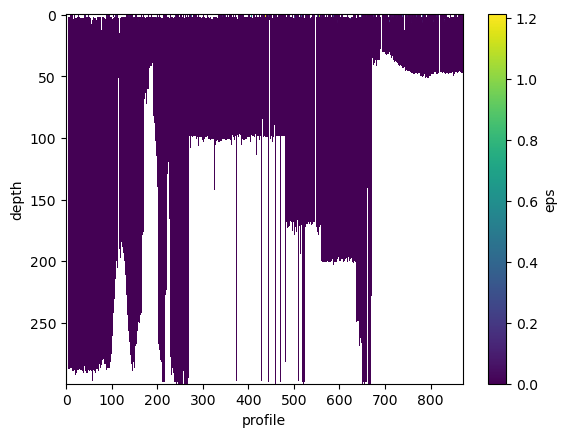

In [15]:
binned_data.eps.plot()
plt.gca().invert_yaxis()

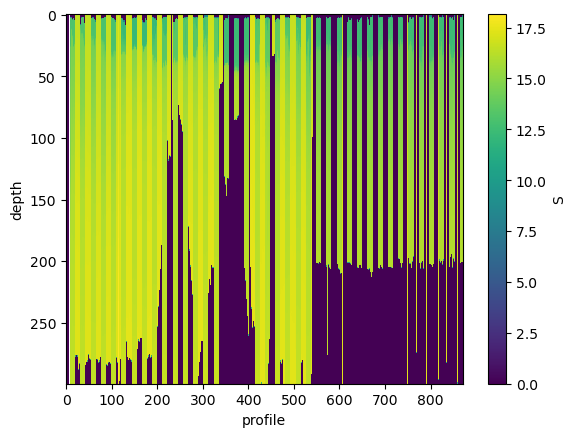

In [16]:
binned_data.S.plot()
plt.gca().invert_yaxis()

## Calculate height above bottom

In [1]:
GEBCO_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc"
#bathy_dataset = Dataset(GEBCO_ds)
bathy_ds = xr.open_dataset(GEBCO_ds)

NameError: name 'xr' is not defined

In [13]:
bathy_ds

<xarray.Dataset>
Dimensions:    (lat: 4080, lon: 9600)
Coordinates:
  * lat        (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon        (lon) float64 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0
Data variables:
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    references:                      DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    node_offset:                     1.0

In [14]:
# Interpolate the bathymetry dataset to the same grid as the masked dataset
bathy_interp = bathy_ds.interp_like(binned_data, method='linear')

# Add the bathymetry data to the masked dataset
binned_data['bathymetry'] = bathy_interp['elevation']

In [15]:
binned_data['bathymetry']

<xarray.DataArray 'bathymetry' (lat: 4080, lon: 9600)>
array([[  -27,   -27,   -27, ...,  1416,  1411,  1388],
       [  -26,   -26,   -25, ...,  1535,  1562,  1590],
       [  -25,   -25,   -24, ...,  1640,  1677,  1742],
       ...,
       [-3302, -3301, -3301, ..., -3363, -3360, -3358],
       [-3301, -3301, -3301, ..., -3364, -3361, -3359],
       [-3300, -3300, -3300, ..., -3364, -3362, -3360]], dtype=int16)
Coordinates:
  * lat      (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon      (lon) float64 -170.0 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [104]:
bathy_interp = bathy_ds.interp_like(binned_data, method='nearest')

from tqdm import tqdm
n_depths = binned_data.profile.shape[0]
depth = np.zeros(n_depths)

for i in tqdm(range(n_depths)):
    microlon = binned_data.longitude[i].values
    #print(binned_data.longitude[0])
    microlat = binned_data.latitude[i].values
    depth[i] = bathy_interp.elevation.sel(lon=microlon,lat=microlat, method='nearest')
binned_data['bathymetry'] = binned_data.profile.copy(data=depth)

  0%|          | 0/871 [00:00<?, ?it/s]


IndexError: Unlabeled multi-dimensional array cannot be used for indexing: lon

In [100]:
from tqdm import tqdm
n_depths = binned_data.profile.shape[0]
depth = np.zeros(n_depths)

for i in tqdm(range(n_depths)):
    microlon = binned_data.longitude[i].values
    #print(binned_data.longitude[0])
    microlat = binned_data.latitude[i].values
    depth[i] = bathy_ds.elevation.sel(lon=microlon,lat=microlat,method='nearest')
binned_data['bathymetry'] = binned_data.profile.copy(data=depth)

  0%|          | 0/871 [00:00<?, ?it/s]


IndexError: Unlabeled multi-dimensional array cannot be used for indexing: lon

In [86]:
Nprof = ds.lat.shape[0]
depth = np.zeros(Nprof)
for i in tqdm(range(Nprof)):
    microlon = ds.lon[i].values
    microlat = ds.lat[i].values
    depth[i] = dsbathy.elevation.sel(lon=microlon,lat=microlat,method='nearest')
ds['depth'] = ds.lat.copy(data=depth)

NameError: name 'ds' is not defined

In [90]:
bathy_interp = bathy_ds.interp_like(binned_data, method='linear')
# index 0 refers to the bathymetry interpolation
bathymetry_broadcast = xr.broadcast(bathy_interp['elevation'], binned_data['single'])[0]
# Broadcast the bathymetry data from 2D to 3D by adding the profile dimension
# bathymetry_broadcast = xr.broadcast(bathy_interp['elevation'], binned_data['profile'])[0]

# Add the bathymetry data to the masked dataset
binned_data['bathymetry'] = bathymetry_broadcast

In [43]:
binned_data

<xarray.Dataset>
Dimensions:     (depth: 300, profile: 871, single: 1, lat: 4080, lon: 9600)
Coordinates:
    latitude    (depth, profile, single) float64 65.23 65.24 ... 65.73 65.73
    longitude   (depth, profile, single) float64 -166.6 -166.6 ... -168.8 -168.8
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * lat         (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon         (lon) float64 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0
Dimensions without coordinates: profile, single
Data variables:
    TIME        (depth, profile, single) float64 7.362e+05 ... 7.362e+05
    eps         (depth, profile) float64 nan nan nan nan nan ... nan nan nan nan
    P           (depth, single) float64 0.625 1.625 2.625 ... 297.6 298.6 299.6
    S           (depth, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T           (depth, profile) float64 nan nan nan 13.6 ... nan nan nan nan
    z           (depth, single) float64 -0.625 -1.625 -2.625 ... -298.6 -299.6
    bathymetry  (lat, lon, single) float64 -27.0 -27.0 ... -3.362e+03 -3.36e+03

In [44]:
binned_data.bathymetry.shape

(4080, 9600, 1)

In [20]:
binned_data.T.shape

(300, 871)

In [46]:
binned_data.bathymetry[3,3,:]

<xarray.DataArray 'bathymetry' (single: 1)>
array([-23.])
Coordinates:
    lat      float64 63.01
    lon      float64 -170.0
Dimensions without coordinates: single
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [25]:
binned_data.bathymetry[1,1,:]

<xarray.DataArray 'bathymetry' (profile: 871)>
array([-26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
...
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26., -26., -26., -26., -26., -26., -26., -26., -26., -26.,
       -26., -26.])
Coordinates:
    lat      float64 63.01
    lon      float64 -170.0
Dimensions without coordinates: profile
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [19]:
binned_data.bathymetry.shape

(4080, 9600, 871)

In [ ]:
bathymetrybathymetry
(lat, lon, profile)
bathymetry.plot()

In [14]:
binned_data.bathymetry.plot()

: 

: 

In [23]:
binned_data["hab"] = binned_data["bathymetry"] + binned_data["depth"] 
# correct for the case where bathymetry is positive
#ds_masked["hab"] = ds_masked['bathymetry'].where(ds_masked['bathymetry'] > 0, 0) - ds_masked['depth']
# Make hab nan where there's no data
#ds_masked["hab"] = xr.where(np.isnan(ds_masked.pot_temp),np.nan,ds_masked.hab)

: 

: 

In [25]:
binned_data["hab"

<xarray.DataArray 'hab' (lat: 4080, lon: 9600, depth: 30)>
array([[[  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        [  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        [  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        ...,
        [ 1416.,  1426.,  1436., ...,  1686.,  1696.,  1706.],
        [ 1411.,  1421.,  1431., ...,  1681.,  1691.,  1701.],
        [ 1388.,  1398.,  1408., ...,  1658.,  1668.,  1678.]],

       [[  -26.,   -16.,    -6., ...,   244.,   254.,   264.],
        [  -26.,   -16.,    -6., ...,   244.,   254.,   264.],
        [  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        ...,
        [ 1535.,  1545.,  1555., ...,  1805.,  1815.,  1825.],
        [ 1562.,  1572.,  1582., ...,  1832.,  1842.,  1852.],
        [ 1590.,  1600.,  1610., ...,  1860.,  1870.,  1880.]],

       [[  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        [  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        [  -24.,   -14.,    -4., ...,   246.,   256.,   266.],
        ...,
...
        ...,
        [-3363., -3353., -3343., ..., -3093., -3083., -3073.],
        [-3360., -3350., -3340., ..., -3090., -3080., -3070.],
        [-3358., -3348., -3338., ..., -3088., -3078., -3068.]],

       [[-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        [-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        [-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        ...,
        [-3364., -3354., -3344., ..., -3094., -3084., -3074.],
        [-3361., -3351., -3341., ..., -3091., -3081., -3071.],
        [-3359., -3349., -3339., ..., -3089., -3079., -3069.]],

       [[-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        [-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        [-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        ...,
        [-3364., -3354., -3344., ..., -3094., -3084., -3074.],
        [-3362., -3352., -3342., ..., -3092., -3082., -3072.],
        [-3360., -3350., -3340., ..., -3090., -3080., -3070.]]])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 40.0 ... 260.0 270.0 280.0 290.0
  * lat      (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon      (lon) float64 -170.0 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0

In [29]:
plt.plot(ds_masked.hab.ravel(),ds_masked.depth)
plt.title("Mean potential temperature with depth")

AttributeError: 'DataArray' object has no attribute 'ravel'

In [21]:
ds_masked

<xarray.Dataset>
Dimensions:      (depth: 30, profiles: 871, single: 1, lat: 4080, lon: 9600)
Coordinates:
  * depth        (depth) float64 0.0 10.0 20.0 30.0 ... 260.0 270.0 280.0 290.0
  * lat          (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon          (lon) float64 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0
Dimensions without coordinates: profiles, single
Data variables:
    LATITUDE     (depth, profiles, single) float64 nan nan nan ... 65.73 65.73
    LONGITUDE    (depth, profiles, single) float64 nan nan nan ... -168.8 -168.8
    TIME         (depth, profiles, single) float64 nan nan ... 7.362e+05
    EPSILON      (depth, profiles) float64 nan nan nan nan ... nan nan nan nan
    PRESSURE     (depth, single, profiles) float64 nan nan nan ... 295.1 295.1
    PSAL         (depth, profiles) float64 nan nan nan 0.0 ... 0.0 0.0 0.0 0.0
    TEMPERATURE  (depth, profiles) float64 nan nan nan 12.34 ... nan nan nan nan
    pot_temp     (depth, profiles, single) float64 nan nan nan ... nan nan nan
    kappa        (depth, profiles, single) float64 nan nan nan ... nan nan nan
    bathymetry   (lat, lon) int16 -27 -27 -27 -26 ... -3366 -3364 -3362 -3360
    hab          (lat, lon, depth) float64 -27.0 -17.0 ... -3.08e+03 -3.07e+03

In [ ]:
# Define height above bottom
ds['hab'] = ds.z - ds.depth
# Correct for where profiles might have negative hab
ds['hab'] = xr.where((ds.hab < 0) & (~np.isnan(ds.pot_temp)), 0, ds.hab)
# Make hab nan where there's no data
ds['hab'] = xr.where(np.isnan(ds.pot_temp),np.nan,ds.hab)

In [54]:
# Create a new dataset with dimensions 'depth' and 'profiles'
bathymetry_ds = xr.Dataset(
    coords={
        'depth': ds_masked.depth.values,
        'profiles': ds_masked.profiles.values
    }
)

# Define a function to interpolate bathymetry values
def interpolate_bathy(lat, lon):
    bathy_value = bathy_interp.elevation.sel(lat=lat, lon=lon, method='nearest').values
    return bathy_value

# Apply the function to each combination of latitude and longitude in ds_masked
bathymetry_ds['elevation'] = xr.apply_ufunc(
    interpolate_bathy, 
    ds_masked.LATITUDE, 
    ds_masked.LONGITUDE, 
    dask='parallelized', 
    output_dtypes=[float]
)# Merge the bathymetry data back into the original dataset
ds_masked = xr.merge([ds_masked, bathymetry_ds])

<xarray.Dataset>
Dimensions:   (depth: 30, profiles: 871)
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 260.0 270.0 280.0 290.0
  * profiles  (profiles) int64 0 1 2 3 4 5 6 7 ... 864 865 866 867 868 869 870
Data variables:
    *empty*

In [254]:
import xarray as xr
import rasterio as rio

# Load the dataset
ds = ds_masked

# Import the rasterio extension
ds.rio.set_crs(ds.attrs['crs'], inplace=True)
bathy_ds = bathy_ds.rio.reproject("EPSG:4326")

# Print the projection
print(ds.rio.crs)

ModuleNotFoundError: No module named 'rasterio'